In [1]:
# Cài đặt thư viện
import MetaTrader5 as mt5
from forex_python.converter import CurrencyRates
import pytz
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from finta import TA
warnings.simplefilter('ignore') 
import simdkalman
import numpy as np
np.int = int
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [2]:
def get_history(symbol:str, timeframe = mt5.TIMEFRAME_D1, start_time: str = "2012-01-01T00:00:00", end_time: str ="2023-12-31T00:00:00") -> pd.DataFrame:
    # Kiểm tra hoạt động của MetaTrader 5
    if not mt5.initialize():
        return {"error": "initialize() failed", "error_code": mt5.last_error()}
    if not mt5.symbol_select(symbol, True):
        return {"error": "Symbol selection failed", "symbol": symbol}
    # Cài đặt thời gian
    timezone = pytz.timezone("Etc/UTC")
    # Tính toán khoảng thời gian từ start_time tới end_time
    start_time = datetime.fromisoformat(start_time).replace(tzinfo=timezone)
    end_time = datetime.fromisoformat(end_time).replace(tzinfo=timezone)
    len_of_bar = end_time - start_time
    # Lấy lịch sử của cặp tiền đó đó
    history = mt5.copy_rates_from(symbol, timeframe, end_time, len_of_bar.days)
    if not mt5.symbol_select(symbol, True):
        return {"error": "Symbol selection failed", "symbol": symbol}
    rates_frame = pd.DataFrame(history)
    rates_frame.index=pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame = rates_frame.loc[start_time.date():end_time.date()]
    rates_frame = rates_frame.rename(columns={'tick_volume': 'volume'})
    rates_frame = rates_frame.drop(['time', 'spread', 'real_volume'], axis=1)
    return rates_frame

In [ ]:
data = get_history("EURCHF")  

In [3]:
# Tạo 1 bộ dữ liệu chứa tất cả các cặp tiền có trong symbols 
def get_data(symbols: list) -> dict:
  data_forex = {}
  for sym in symbols:
    data = get_history(sym)
    data_forex[sym] = data
  return data_forex

In [4]:
symbols = ["EURCHF", "NZDUSD", "NZDJPY", "USDJPY", "AUDNZD"]
data_forex = get_data(symbols)

In [ ]:
data_forex["EURCHF"].head(20)

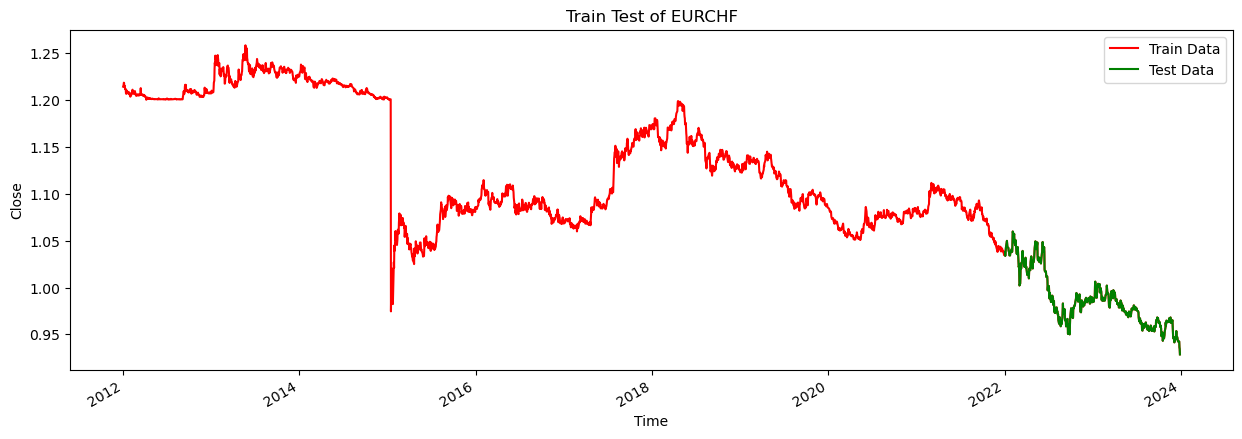

In [6]:
# Vẽ biểu đồ mô tả đữ liệu
data = data_forex["EURCHF"]['close']
fig, ax = plt.subplots(figsize=(15, 5))
data.plot(ax=ax, color='red', label='Train Data')
# Lọc dữ liệu từ năm 2022 đến 2023
mask = (data.index >= '2022-01-01') & (data.index <= '2023-12-31')
data_2022_2023 = data.loc[mask]
# Vẽ đường của dữ liệu năm 2022-2023 với màu xanh lá cây
data_2022_2023.plot(ax=ax, color='green', label='Test Data')
# Thiết lập tên trục và tiêu đề
ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.set_title('Train Test of EURCHF')
# Hiển thị chú thích
ax.legend()
# Hiển thị đồ thị
plt.show()

In [7]:
#  Hàm này để tạo thêm các đặc trưng từ thư viện finta
def create_indicators(ohlcv: pd.DataFrame) -> pd.DataFrame:
    data = ohlcv.copy()
    indi, signal = bias(ohlcv)
    data = pd.concat([data, indi], axis=1)
    data['BIAS_signal'] = signal
    data['VR'], data["VR_signal"] = vr(ohlcv)
    data['TRIX'], data["TRIX_signal"] = trix(ohlcv)
    data['ER'] = TA.ER(ohlcv)
    data['EVWMA'] = TA.EVWMA(ohlcv)
    data['VWAP'] = TA.VWAP(ohlcv)
    data['MOM'] = TA.MOM(ohlcv)
    data['ROC'] = TA.ROC(ohlcv)
    data['RSI'] = TA.RSI(ohlcv)
    data['IFT_RSI'] = TA.IFT_RSI(ohlcv)
    data['ATR'] = TA.ATR(ohlcv)
    data['BBWIDTH'] = TA.BBWIDTH(ohlcv)
    data['ADX'] = TA.ADX(ohlcv)
    data['STOCH'] = TA.STOCH(ohlcv)
    data['STOCHD'] = TA.STOCHD(ohlcv)
    data['AO'] = TA.AO(ohlcv)
    data['MI'] = TA.MI(ohlcv)
    data['MFI'] = TA.MFI(ohlcv)
    data['PZO'] = TA.PZO(ohlcv)
    data['EFI'] = TA.EFI(ohlcv)
    data['EMV'] = TA.EMV(ohlcv)
    data['CCI'] = TA.CCI(ohlcv)
    data['FISH'] = TA.FISH(ohlcv)
    data['FVE'] = TA.FVE(ohlcv)

    macd = TA.MACD(ohlcv)
    data['MACDCal'] = macd['MACD'] - macd['SIGNAL']

    macdev = TA.EV_MACD(ohlcv)
    data['EVMACD'] = macdev["MACD"]

    data['TR'] = TA.TR(ohlcv)

    DMI = TA.DMI(ohlcv)
    data['DMI+'] = DMI["DI+"]
    data['DMI-'] = DMI["DI-"]

    VORTEX = TA.VORTEX(ohlcv)
    data['VIp'] = VORTEX["VIp"]
    data['ADL'] = TA.ADL(data)

    TSI = TA.TSI(ohlcv)
    data['TSI'] = TSI["TSI"]
    data['TSIsignal'] = TSI["signal"]

    KST = TA.KST(ohlcv)
    data['KST'] = KST["KST"]

    data['CHAIKIN'] = TA.CHAIKIN(ohlcv)
    data['OBV'] = TA.OBV(ohlcv)
    data['WOBV'] = TA.WOBV(ohlcv)

    EBBP = TA.EBBP(ohlcv)
    data['EBBPBull'] = EBBP["Bull."]
    data['EBBPBear'] = EBBP["Bear."]

    BASPN = TA.BASPN(ohlcv)
    data['BASPNBuy'] = BASPN["Buy."]
    data['BASPNSell'] = BASPN["Sell."]
    data['COPP'] = TA.COPP(ohlcv)

    BASP = TA.BASP(ohlcv)
    data['BASPBuy'] = BASP["Buy."]
    data['BASPSell'] = BASP["Sell."]

    WTO = TA.WTO(ohlcv)
    data['WTOWT1'] = WTO["WT1."]

    data['STC'] = TA.STC(ohlcv)
    data['VPT'] = TA.VPT(ohlcv)
    return data

#Hàm này để lấy các ngày liên tiếp theo n_days để làm các cột dữ liệu
def add_past_days_as_feature(data: pd.DataFrame, n_days: int) -> pd.DataFrame:
    data = pd.concat([data.shift(i).add_suffix(f"_{i}") for i in range(n_days)], axis=1)
    return data

#Hàm Bias dùng để so sánh giữ hai hai tính hiệu dài hạn và ngắn hạn vựa trên short_val và long_val
def bias(prices : pd.DataFrame) -> pd.Series:
    short_avg = prices['close'].rolling(3, min_periods=1).mean()
    long_avg = prices['close'].rolling(5, min_periods=1).mean()
    short_val = pd.Series(((prices['close'] - short_avg) / short_avg) * 100, name="BIAS_short", index=prices.index)
    long_val = pd.Series(((prices['close'] - long_avg) / long_avg) * 100, name="BIAS_long", index=prices.index)
    indi = pd.concat([short_val, long_val], axis=1)
    # So sánh xem dài hạn hay ngắn hạn cái nào sẽ lời hơn
    signal = pd.Series((long_val > short_val).astype(int), name="BIAS_signal", index=prices.index)
    return indi, signal
# Hàm tính giá trị VR
def vr(prices: pd.DataFrame) -> pd.Series:
    # Lấy giá cao nhất ngày hiện tạo cộng cho ngày đóng cửa của tương lai
    maximum = (prices['high'] + prices['close'].shift(1).bfill()).mean()
    minimum = (prices['low'] + prices['close'].shift(1).bfill()).mean()
    # Tính trung bình động cho giá 'high' và 'low' trong cửa sổ 14 ngày
    high = prices['high'].rolling(14, min_periods=1).mean()
    low = prices['low'].rolling(14, min_periods=1).mean()
    indi = pd.Series((maximum - minimum) / (high - low), name="VR", index=prices.index)
    signal = pd.Series((indi > 0.5).astype(int), name="VR_signal", index=prices.index)
    return indi, signal
# Hàm tính giá trị Trix
def trix(prices: pd.DataFrame) -> pd.Series:
    indi = TA.TRIX(prices, 10)
    # Tạo tín hiệu TRIX (1 nếu TRIX < 0, ngược lại 0)
    signal = pd.Series((indi < 0).astype(int), name="TRIX_signal", index=prices.index)
    return indi, signal

In [7]:
# Hàm tính tổng lời lỗ
def calculate_total_profit(y_pred, prices):
    profit = 0
    for i in range(1, len(prices)):
        if y_pred[i-1] == 1:  # Dự đoán là tăng
            profit += prices[i] - prices[i-1]  # Lợi nhuận từ việc mua và sau đó bán
        elif y_pred[i-1] == -1:  # Dự đoán là giảm
            profit += prices[i-1] - prices[i]  # Lợi nhuận từ việc bán và sau đó mua lại
    return profit

In [8]:
# tính lợi nhuận thực tế
def caculate_profit(sym,y_pred,prices):
  # Khởi tạo các biến để tính tiền
  usd_rate = {"EURCHF":1.11,'NZDUSD':1,'NZDJPY': 0.0066,'USDJPY':0.0066, 'AUDNZD':0.59}
  volume = 0.01
  contract_size = 100000
# Sau đó tính tiền
  total_profit = calculate_total_profit(y_pred,prices)
  profit = total_profit*volume*contract_size*usd_rate[sym]
  return profit

In [10]:
def set_up_features(data_new,look_back=10):
    y = {}
    # y ở đây là ngày mai tăng hay giảm
    # Y lấy dữ liệu giá đóng cửa. Nếu giá trị đang Nan thì điền vào giá trị gần nhất của cột Close
    for symbol in data_new.keys():
        y[symbol] = data_new[symbol]["close"].ffill()
    # x là features
    X = {}
    # Đoạn này lấy dữ liệu X là data dùng để tách train, test
    for symbol in data_new.keys():
        X_base_features = create_indicators(data_new[symbol])
        X[symbol] = add_past_days_as_feature(data=X_base_features, n_days=look_back)
        X[symbol]["label"] = y[symbol].copy()
        X[symbol] = X[symbol].dropna(axis=0)
        y[symbol] = X[symbol]["label"].copy()
    return X,y

In [11]:
X,y = set_up_features(data_forex)

In [16]:
# Chia dữ liệu với test (2022-2023) và train (còn lại)
def split_data_scale(X: dict, y: dict) -> dict:
    data_all_money = {}
    for sym in X.keys():
        X_ori = X[sym].copy()
        col_df = X_ori.columns
        y_ori = pd.Series(y[sym])
        X_train = X_ori.loc[X_ori.index < pd.to_datetime('2022-01-01')]
        X_test = X_ori.loc[X_ori.index >= pd.to_datetime('2022-01-01')]
        y_train = y_ori.loc[y_ori.index < pd.to_datetime('2022-01-01')]
        y_test = y_ori.loc[y_ori.index >= pd.to_datetime('2022-01-01')]
        prices = X_test['close_0'].copy().to_numpy()
        scaler = MinMaxScaler()
        train_index = X_train.index
        test_index = X_test.index
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.fit_transform(X_test)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns = col_df)
        X_test_scaled =  pd.DataFrame(X_test_scaled, columns = col_df)
        X_train_scaled.index = train_index
        X_test_scaled.index = test_index
        X_train_scaled = X_train_scaled.drop(columns = ["label"])
        X_test_scaled = X_test_scaled.drop(columns = ["label"])
        data_all_money[sym] = [X_train_scaled, X_test_scaled, y_train, y_test,prices]
    return data_all_money

In [17]:
data_all_money = split_data_scale(X,y)

In [ ]:
len(data_all_money['NZDUSD'][1])

In [18]:
# smooth data để smooth ta cần biết các dữ liệu nhiễu thường xuyên, và bộ dữ liệu thực tế
# Việc cần ở đây là chỉ số nhiễu tượng trưng cho dữ liệu đó chỉ cần chỉnh bao nhiêu phần trăm bị nhiễu
def Smoothing_data(y) -> dict:
  symbolsmooths = {}
  #cho nhiều bộ smooths y khác nhau để xem cái nào tốt nhất
  for syms in y.keys():
    smooths = []
    for isf in range(4,5):
        for ins in range(4,5):
            smoothing_factor = isf
            n_seasons = ins
            # --- define state transition matrix A tạo ma trận n_season+1
            state_transition = np.zeros((n_seasons+1, n_seasons+1))
            # hidden level         Đặt mặc định số đầu tiên là 1
            state_transition[0,0] = 1
            # season cycle         Sau đó ta chỉnh các thông sô khác cho mặc định dòng 1 có n_season = -1
            state_transition[1,1:-1] = [-1.0] * (n_seasons-1)
            # Tạo đường chéo chính có giá trị là 1
            state_transition[2:,1:-1] = np.eye(n_seasons-1)
            # --- observation model H
            # observation is hidden level + weekly seasonal compoenent
            observation_model = [[1,1] + [0]*(n_seasons-1)]
            # --- noise models, parametrized by the smoothing factor
            level_noise = 0.2 / smoothing_factor
            observation_noise = 0.2
            season_noise = 1e-3
            process_noise_cov = np.diag([level_noise, season_noise] + [0]*(n_seasons-1))**2
            observation_noise_cov = observation_noise**2
            # Sử dụng Kalman filter
            kf = simdkalman.KalmanFilter(
                state_transition, # Hiển thị cách model chuyển tiếp để thay đổi ( Đây là cách nhìn dữ liệu bị nhiễu)
                process_noise_cov, # ma trận biểu thị mức độ nhiễu của mô hình (Đây là để biết nhiễu thường xảy ra với tuần suât nào)
                observation_model, #  Là mô hình quan sát của hệ thông thường là ma trận hay hàm số biểu thị (Đây là  kết quả hiện tại đang cần chỉnh nhiễu)
                observation_noise_cov #  Ma trận biểu thị mức độ nhiễu trong đo lường  (Đây giống như là sai số để xem kết quả dự đoán với thực tế thì sau bnhieu)
                )
            # Sau đó ta tính toán lấy ra được các dự đoán nhiễu và trả về dự đoán bị nhiễu được quy định bằng các tham số trên
            block = y[syms]
            n_train = block.shape[0]
            n_test = 60
            result = kf.compute(block, n_test)
            predictproba = result.smoothed.states.mean[:,0]
            y_label = []
            for ivalue in range(1,len(predictproba)):
                if(predictproba[ivalue] > predictproba[ivalue-1]):
                    y_label.append(1)
                else:
                    y_label.append(-1)
            smooths.append(y_label)
    symbolsmooths[syms] = smooths
  return symbolsmooths

In [19]:
# Sau khi có được bộ nhiễu thì tiến hành đi làm mịn nhãn
def smooth_label(y_train_ ,symbolsmooths, symbol):
  # Hàm chỉnh dữ liệu lại cho smooth
  y_train = []
  y_test = []
  # chạy từng mã gán lại nhãn đã smooth, -1 là 0 giảm, 1 là 1 tăng
  for idx in range(len(y_train_)):
      if symbolsmooths[symbol][0][idx]  == -1:
          y_train.append(0)
      else:
          y_train.append(1)
  # y_test cũng vậy, phần test sẽ là phần còn lại tính từ n_split
  for idx in range(len(symbolsmooths[symbol][0]) - len(y_train_)):
      if symbolsmooths[symbol][0][idx+ len(y_train_)] == -1:
          y_test.append(0)
      else:
          y_test.append(1)
  y_test.append(1)
  return y_train, y_test

In [22]:
# cài đặt lại để tạo thành train test hoàn chỉnh
def create_train_test(X, y):
  data_all = {}
  data_all_money = split_data_scale(X,y)
  symbolsmooth_y = Smoothing_data(y)
  for sym in X.keys():
    X_train, X_test, y_train, y_test,prices = data_all_money[sym]
    # Sau khi smooth data ta có y_train và y_test mới
    y_train, y_test = smooth_label( y_train, symbolsmooth_y, sym)
    data_set = pd.get_dummies(X_train, drop_first=False)
    data_all[sym] = [data_set, X_test, y_train, y_test]
  return data_all

In [23]:
data_all = create_train_test(X,y)

In [ ]:
data_all['AUDNZD'][2]

In [ ]:
import matplotlib.pyplot as plt
def plot_data(data_forex):
    for sym in data_forex.keys():
        data = data_forex[sym]['close']
        fig, ax = plt.subplots(figsize=(15, 5))
        data.plot(ax=ax, color='red', label='Train Data')
        mask = (data.index >= '2022-01-01') & (data.index <= '2023-12-31')
        data_2022_2023 = data.loc[mask]
        data_2022_2023.plot(ax=ax, color='green', label='Test Data')
        ax.set_xlabel('Time')
        ax.set_ylabel('Close')
        ax.set_title(f'Train Test of {sym}')
        # Hiển thị chú thích
        ax.legend()
        # Hiển thị đồ thị
        plt.show()

In [ ]:
plot_data(data_forex)

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

In [ ]:
_ = data_all['AUDNZD'][1]['close_0'].plot(kind='line', figsize=(15,5), color=color_pal[0], title='SMA')

In [24]:
# Hàm khởi tạo Isolation forest cho việc loại bỏ các outlier vựa trên decision Tree
# Nó chỉ loại bỏ 1 phần bị outliers
def create_clf(X_train):
  clf = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    n_jobs=-1,
    random_state=2023)
  clf.fit(X_train)
  return clf
# hàm tạo ngưỡng nhiễu
def outlier_threshold(normality, k=1.5):
  q1 = np.quantile(normality, 0.2)
  q3 = np.quantile(normality, 0.8)
  threshold = q1 - k*(q3-q1)
  return threshold
# Hàm loại bỏ outlier cho tập data train
def delete_outlier(clf, X_train, y_train):
  # Lấy ngưỡng cho dữ liệu
  normality_df = pd.DataFrame(clf.decision_function(X_train), columns=['normality'])
  threshold = outlier_threshold(normality_df['normality'].values, k=1.5)
  # Sau đo ta loại bỏ dòng bị outlier
  X_train = X_train[normality_df['normality'].values>=threshold]
  y_train = y_train[normality_df['normality'].values>=threshold]
  return X_train, y_train

def data_np(data_all):
  for sym in data_all.keys():
    # Thay đổi dữ liệu về dạng làm tròn và numpy
    data_all[sym][2] = np.array(data_all[sym][2])
    data_all[sym][3] = np.array(data_all[sym][3])
    data_all[sym][0] = data_all[sym][0].astype(np.float32)
    data_all[sym][1] = data_all[sym][1].astype(np.float32)
  return data_all
# loại bỏ các outlier của từng đồng
def delete_outlier_data(data_all):
  data_all = data_np(data_all)
  for sym in data_all.keys():
    clf = create_clf(data_all[sym][0])
    data_all[sym][0], data_all[sym][2] = delete_outlier(clf, data_all[sym][0], data_all[sym][2])
  return data_all

In [25]:
# tạo ra 1 dataframe để chứa thông tin các bộ mô hình
def setup_cv(model_name):
  model_list = []
  # mỗi model chuẩn bị 5 cái loss tốt nhất vì chạy CV
  for name in model_name:
    model_list.append(np.full(5, name))
  cv_df = pd.DataFrame({'model': np.hstack((model_list)), 'accuracy':None, 'best_hyper_param':None})
  return cv_df
def create_best_cv (symbols, model_name):
  best_cv_df = {}
  for sym in symbols:
    best_cv_df[sym] = setup_cv(model_name)
  return best_cv_df

In [26]:
model_name = [ 'rf', 'xgb', 'mlp','svm','catboost' ]
best_cv_df = create_best_cv(symbols, model_name)

In [27]:
data_all = delete_outlier_data(data_all)

In [28]:
# cài cặt  thực hiện siêu tham số cho rf
def optimizer_rf_model(X_train, y_train, best_cv_df, sym):
  param_grid = {
    'n_estimators': [200,250,300,350,400],
    'max_depth' : list(range(8,10)),
    'criterion' :['entropy'],
    'min_samples_leaf': list(range(5,10)),
    'min_samples_split': list(range(8,10)),
  }
  rfc=RandomForestClassifier(random_state=23)
  rf_search = GridSearchCV(estimator=rfc, param_grid=param_grid,n_jobs =6,scoring='accuracy', verbose = 2,refit='accuracy',cv= 3)
  rf_search.fit(X_train, y_train)

  model_name = 'rf'
  accuracies = rf_search.cv_results_["mean_test_score"]
  best_hyperparameter = rf_search.cv_results_["params"]

  # Lấy ra 5 parameter tốt nhất
  top_5_indices = (-accuracies).argsort()[:5]
  top_5_hyperparameter = [best_hyperparameter[i] for i in top_5_indices]
  cv_df = pd.DataFrame(rf_search.cv_results_)
  # Lấy trung bình dự đoán độ chinh xác khi trên tập kfold của tùng best hyperparameter
  acc = []
  for i in range(len(cv_df)):
    if cv_df["params"].values[i] in top_5_hyperparameter:
      a = [cv_df["split0_test_score"].values[i], cv_df["split1_test_score"].values[i], cv_df["split2_test_score"].values[i]]
      acc.append(round(sum(a)/3, 5)) # Tính trung bình cho từng hyperparameter khi làm xong việc test fold = 3

  best_cv_df[sym].loc[best_cv_df[sym]['model']==model_name, 'best_hyper_param'] = top_5_hyperparameter
  best_cv_df[sym].loc[best_cv_df[sym]['model']==model_name, 'accuracy'] = acc
  # lưu lại 5 model tốt nhất bằng random forest
  return rf_search
    

In [ ]:
def optimizer_xgb_model(X_train, y_train, best_cv_df, sym):
    parameters = {
      # Các Hyper parameter cần tính toán
    'n_estimators': [100],
    'learning_rate': [0.1,0.05],
    'min_child_weight': [5],
    'gamma': [0.5],
    'subsample': [0.6],
    'colsample_bytree': [1.0, 2],
    'max_depth': [5,8],
    'objective': ['binary:logistic'],
    'use_label_encoder': [False]
    }
    xgb=XGBClassifier(random_state=23)
    xgb_search = GridSearchCV(estimator=xgb, param_grid=parameters,n_jobs =6,scoring='accuracy', verbose =2,refit='accuracy',cv= 3)
    xgb_search.fit(X_train, y_train)

    model_name = 'xgb'
    accuracies = xgb_search.cv_results_["mean_test_score"]
    best_hyperparameter = xgb_search.cv_results_["params"]
    # Lấy ra 5 parameter tốt nhất
    top_5_indices = (-accuracies).argsort()[:5]
    top_5_hyperparameter = [best_hyperparameter[i] for i in top_5_indices]
    cv_df = pd.DataFrame(xgb_search.cv_results_)
    # Lấy trung bình dự đoán độ chinh xác khi trên tập kfold của tùng best hyperparameter
    acc = []
    for i in range(len(cv_df)):
        if cv_df["params"].values[i] in top_5_hyperparameter:
          a = [cv_df["split0_test_score"].values[i], cv_df["split1_test_score"].values[i], cv_df["split2_test_score"].values[i]]
          acc.append(round(sum(a)/3, 5)) # Tính trung bình cho từng hyperparameter khi làm xong việc test fold = 3
    best_cv_df[sym].loc[best_cv_df[sym]['model']==model_name, 'best_hyper_param'] = top_5_hyperparameter
    best_cv_df[sym].loc[best_cv_df[sym]['model']==model_name, 'accuracy'] = acc
    # lưu lại 5 model tốt nhất bằng random forest
    return xgb_search

In [ ]:
def optimizer_mlp_model(X_train, y_train, best_cv_df, sym):
  param_grid = {
      'hidden_layer_sizes': [(120,80,40),(100,60,30)],
      'max_iter': [80, 100],
      'activation': ['tanh'],
      'solver': ['sgd'],
      'alpha': [0.05,0.1],  # Chỉ số cần được chỉnh
      'learning_rate': ['constant','adaptive'],
  }
  mlp = MLPClassifier()
  # Đoạn dưới đây là chạy Grid search cho model
  mlp_search = GridSearchCV(mlp, param_grid, n_jobs= 6, cv=3)
  mlp_search.fit(X_train, y_train)

  model_name = 'mlp'
  accuracies = mlp_search.cv_results_["mean_test_score"]
  best_hyperparameter = mlp_search.cv_results_["params"]

  # Lấy ra 5 parameter tốt nhất
  top_5_indices = (-accuracies).argsort()[:5]
  top_5_hyperparameter = [best_hyperparameter[i] for i in top_5_indices]
  cv_df = pd.DataFrame(mlp_search.cv_results_)

  # Lấy trung bình dự đoán độ chinh xác khi trên tập kfold của tùng best hyperparameter
  acc = []
  for i in range(len(cv_df)):
    if cv_df["params"].values[i] in top_5_hyperparameter:
      a = [cv_df["split0_test_score"].values[i], cv_df["split1_test_score"].values[i], cv_df["split2_test_score"].values[i]]
      acc.append(round(sum(a)/3, 5)) # Tính trung bình cho từng hyperparameter khi làm xong việc test fold = 3

  best_cv_df[sym].loc[best_cv_df[sym]['model']==model_name, 'best_hyper_param'] = top_5_hyperparameter
  best_cv_df[sym].loc[best_cv_df[sym]['model']==model_name, 'accuracy'] = acc

  return mlp_search

In [ ]:
def optimizer_svm_model(X_train, y_train, best_cv_df, sym):
  param_grid = {
      'C': [0.5,0.75,1.0],
      'kernel': ['linear', 'sigmoid','rbf'],
      'gamma': ['scale'],
      'class_weight':['balanced']
  }
  svm = SVC()
  # Đoạn dưới đây là chạy Grid search cho model
  svm_search = GridSearchCV(svm, param_grid, n_jobs= 6, cv=3)
  svm_search.fit(X_train, y_train)

  model_name = 'svm'
  accuracies = svm_search.cv_results_["mean_test_score"]
  best_hyperparameter = svm_search.cv_results_["params"]

  # Lấy ra 5 parameter tốt nhất
  top_5_indices = (-accuracies).argsort()[:5]
  top_5_hyperparameter = [best_hyperparameter[i] for i in top_5_indices]
  cv_df = pd.DataFrame(svm_search.cv_results_)

  # Lấy trung bình dự đoán độ chinh xác khi trên tập kfold của tùng best hyperparameter
  acc = []
  for i in range(len(cv_df)):
    if cv_df["params"].values[i] in top_5_hyperparameter:
      a = [cv_df["split0_test_score"].values[i], cv_df["split1_test_score"].values[i], cv_df["split2_test_score"].values[i]]
      acc.append(round(sum(a)/3, 5)) # Tính trung bình cho từng hyperparameter khi làm xong việc test fold = 3

  best_cv_df[sym].loc[best_cv_df[sym]['model']==model_name, 'best_hyper_param'] = top_5_hyperparameter
  best_cv_df[sym].loc[best_cv_df[sym]['model']==model_name, 'accuracy'] = acc

  return svm_search

In [ ]:
def optimizer_cat_model(X_train, y_train, best_cv_df, sym):
  param_grid = {
      'iterations': [100,150,200],
      'learning_rate': [0.1,0.05],
      'depth': [5,6,7],
      'verbose': [0,1]
  }
  catboost = CatBoostClassifier()
  # Đoạn dưới đây là chạy Grid search cho model
  cat_search = GridSearchCV(catboost, param_grid, n_jobs= 6, cv=3)
  cat_search.fit(X_train, y_train)

  model_name = 'catboost'
  accuracies = cat_search.cv_results_["mean_test_score"]
  best_hyperparameter = cat_search.cv_results_["params"]

  # Lấy ra 5 parameter tốt nhất
  top_5_indices = (-accuracies).argsort()[:5]
  top_5_hyperparameter = [best_hyperparameter[i] for i in top_5_indices]
  cv_df = pd.DataFrame(cat_search.cv_results_)

  # Lấy trung bình dự đoán độ chinh xác khi trên tập kfold của tùng best hyperparameter
  acc = []
  for i in range(len(cv_df)):
    if cv_df["params"].values[i] in top_5_hyperparameter:
      a = [cv_df["split0_test_score"].values[i], cv_df["split1_test_score"].values[i], cv_df["split2_test_score"].values[i]]
      acc.append(round(sum(a)/3, 5)) # Tính trung bình cho từng hyperparameter khi làm xong việc test fold = 3

  best_cv_df[sym].loc[best_cv_df[sym]['model']==model_name, 'best_hyper_param'] = top_5_hyperparameter
  best_cv_df[sym].loc[best_cv_df[sym]['model']==model_name, 'accuracy'] = acc

  return cat_search

## Chia thành huấn luyện từng mô hình để giảm tải áp lực cho máy

In [ ]:
def get_rf_models_results(data_all, best_cv_df):
    model_rf_results = {}
    for sym in data_all.keys():
        print(sym)
        X_train = data_all[sym][0]
        y_train = data_all[sym][2]
        rf_search = optimizer_rf_model(X_train,y_train,best_cv_df,sym)
        model_rf_results[sym] = rf_search
    return model_rf_results

In [ ]:
model_rf_results = get_rf_models_results(data_all,best_cv_df)

In [ ]:
def get_xgb_models_results(data_all, best_cv_df):
    model_xgb_results = {}
    for sym in data_all.keys():
        print(sym)
        X_train = data_all[sym][0]
        y_train = data_all[sym][2]
        xgb_search = optimizer_xgb_model(X_train,y_train,best_cv_df,sym)
        model_xgb_results[sym] = xgb_search
    return model_xgb_results

In [ ]:
model_xgb_results = get_xgb_models_results(data_all,best_cv_df)

In [ ]:
def get_mlp_models_results(data_all, best_cv_df):
    model_mlp_results = {}
    for sym in data_all.keys():
        print(sym)
        X_train = data_all[sym][0]
        y_train = data_all[sym][2]
        mlp_search = optimizer_mlp_model(X_train,y_train,best_cv_df,sym)
        model_mlp_results[sym] = mlp_search
    return model_mlp_results

In [ ]:
model_mlp_results = get_mlp_models_results(data_all,best_cv_df)

In [ ]:
def get_svm_models_results(data_all, best_cv_df):
    model_svm_results = {}
    for sym in data_all.keys():
        print(sym)
        X_train = data_all[sym][0]
        y_train = data_all[sym][2]
        svm_search = optimizer_svm_model(X_train,y_train,best_cv_df,sym)
        model_svm_results[sym] = svm_search
    return model_svm_results

In [ ]:
model_svm_results = get_svm_models_results(data_all,best_cv_df)

In [ ]:
def get_cat_models_results(data_all, best_cv_df):
    model_cat_results = {}
    for sym in data_all.keys():
        print(sym)
        X_train = data_all[sym][0]
        y_train = data_all[sym][2]
        cat_search = optimizer_cat_model(X_train,y_train,best_cv_df,sym)
        model_cat_results[sym] = cat_search
    return model_cat_results

In [ ]:
model_cat_results = get_cat_models_results(data_all,best_cv_df)

In [ ]:
#lưu mô hình
# with open("D:/ĐACS/all_models_parameter.pkl", 'wb') as file:  # Use 'rb' for binary mode
#     pickle.dump(best_cv_df, file)

In [2]:
# kiểm tra lại file đã lưu
import pickle
import pandas as pd
with open("D:/ĐACS/all_models_parameter.pkl", 'rb') as file:  # Use 'rb' for binary mode
    best_cv_df = pickle.load(file, encoding='latin-1')  # Replace 'latin-1' with the actual encoding

In [3]:
best_cv_df['AUDNZD']

,model,accuracy,best_hyper_param
0,rf,0.61103,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
1,rf,0.60957,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
2,rf,0.61103,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."
3,rf,0.61176,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."
4,rf,0.61176,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."
5,xgb,0.62707,"{'colsample_bytree': 1.0, 'gamma': 0.5, 'learn..."
6,xgb,0.62853,"{'colsample_bytree': 1.0, 'gamma': 0.5, 'learn..."
7,xgb,0.62852,"{'colsample_bytree': 1.0, 'gamma': 0.5, 'learn..."
8,xgb,0.63217,"{'colsample_bytree': 1.0, 'gamma': 0.5, 'learn..."
9,xgb,NaN,"{'colsample_bytree': 2, 'gamma': 0.5, 'learnin..."


In [24]:
symbols = ["EURCHF", "NZDUSD", "NZDJPY", "USDJPY", "AUDNZD"]
model_name = ['rf', 'xgb', 'mlp', 'svm', 'catboost']
sorted_cv_df = {}
for sym in symbols:
    sorted_df = best_cv_df[sym].copy()
    sorted_df['model'] = pd.Categorical(sorted_df['model'], categories=model_name, ordered=True)
    sorted_df = sorted_df.sort_values(by=['model', 'accuracy'], ascending=[True, False])
    sorted_cv_df[sym] = sorted_df.reset_index(drop=True)

In [26]:
for sym in symbols:
    print(sym)
    print(sorted_cv_df[sym]['best_hyper_param'][0])
    print(sorted_cv_df[sym]['best_hyper_param'][5])
    print(sorted_cv_df[sym]['best_hyper_param'][10])
    print(sorted_cv_df[sym]['best_hyper_param'][15])
    print(sorted_cv_df[sym]['best_hyper_param'][20])
    print('----------------------------------------------------------------')

EURCHF
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 400}
{'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'subsample': 0.6, 'use_label_encoder': False}
{'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (120, 80, 40), 'learning_rate': 'adaptive', 'max_iter': 80, 'solver': 'sgd'}
{'C': 0.5, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
{'depth': 7, 'iterations': 100, 'learning_rate': 0.05, 'verbose': 1}
----------------------------------------------------------------
NZDUSD
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}
{'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'subsample': 0.6, 'use_label_encoder': False}
{'activation': 'tanh

0:	learn: 0.6814172	total: 238ms	remaining: 23.6s
1:	learn: 0.6691425	total: 343ms	remaining: 16.8s
2:	learn: 0.6588085	total: 444ms	remaining: 14.3s
3:	learn: 0.6483985	total: 560ms	remaining: 13.5s
4:	learn: 0.6377015	total: 677ms	remaining: 12.9s
5:	learn: 0.6264383	total: 789ms	remaining: 12.4s
6:	learn: 0.6167652	total: 897ms	remaining: 11.9s
7:	learn: 0.6097522	total: 1000ms	remaining: 11.5s
8:	learn: 0.6015457	total: 1.11s	remaining: 11.3s
9:	learn: 0.5910806	total: 1.23s	remaining: 11s
10:	learn: 0.5835369	total: 1.35s	remaining: 11s
11:	learn: 0.5766600	total: 1.5s	remaining: 11s
12:	learn: 0.5687985	total: 1.68s	remaining: 11.3s
13:	learn: 0.5610510	total: 1.81s	remaining: 11.1s
14:	learn: 0.5545855	total: 1.92s	remaining: 10.9s
15:	learn: 0.5479364	total: 2.03s	remaining: 10.7s
16:	learn: 0.5414496	total: 2.17s	remaining: 10.6s
17:	learn: 0.5343430	total: 2.28s	remaining: 10.4s
18:	learn: 0.5290887	total: 2.39s	remaining: 10.2s
19:	learn: 0.5244624	total: 2.5s	remaining: 10s

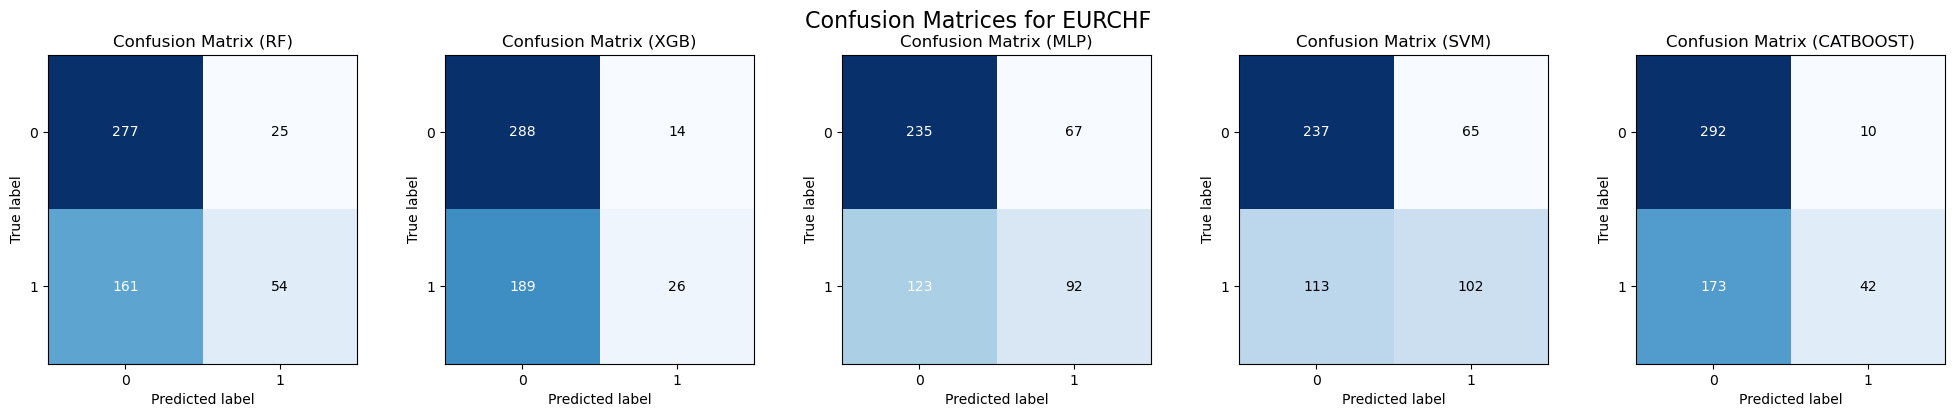

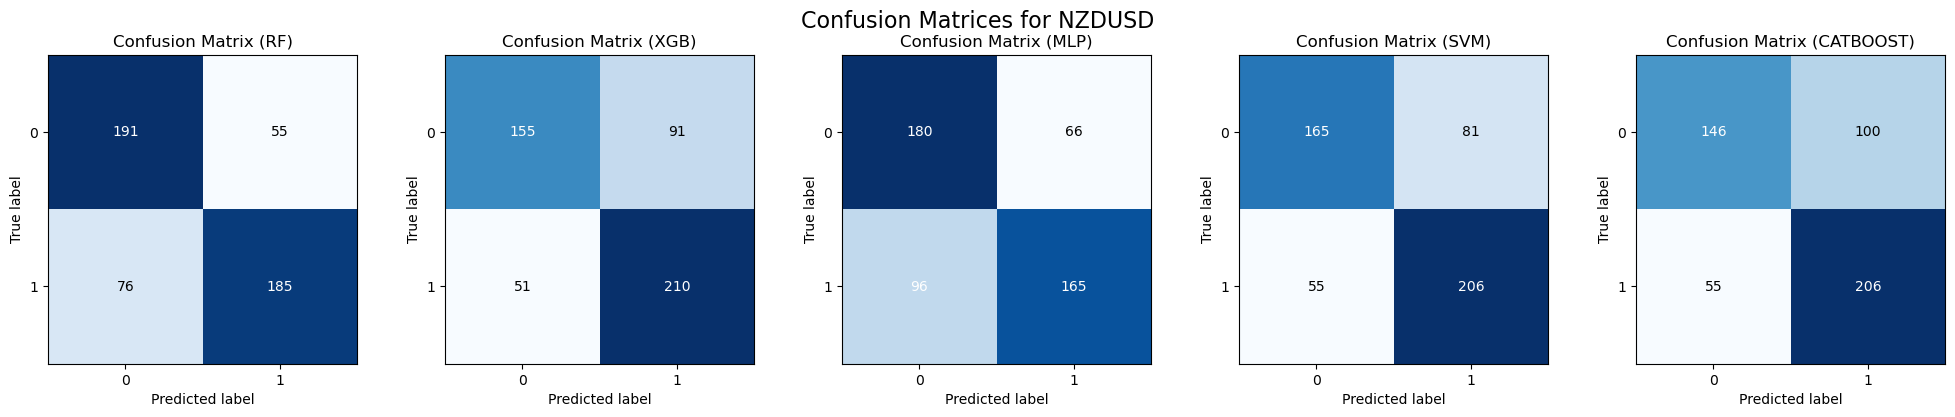

0:	learn: 0.6573806	total: 158ms	remaining: 23.5s
1:	learn: 0.6317450	total: 288ms	remaining: 21.3s
2:	learn: 0.6078670	total: 448ms	remaining: 21.9s
3:	learn: 0.5880035	total: 647ms	remaining: 23.6s
4:	learn: 0.5643300	total: 925ms	remaining: 26.8s
5:	learn: 0.5451829	total: 1.08s	remaining: 26s
6:	learn: 0.5325500	total: 1.24s	remaining: 25.4s
7:	learn: 0.5181234	total: 1.39s	remaining: 24.7s
8:	learn: 0.5013660	total: 1.56s	remaining: 24.5s
9:	learn: 0.4903089	total: 1.7s	remaining: 23.8s
10:	learn: 0.4804994	total: 1.86s	remaining: 23.5s
11:	learn: 0.4717670	total: 2.02s	remaining: 23.3s
12:	learn: 0.4615890	total: 2.16s	remaining: 22.8s
13:	learn: 0.4507410	total: 2.41s	remaining: 23.4s
14:	learn: 0.4413502	total: 2.6s	remaining: 23.4s
15:	learn: 0.4263491	total: 2.78s	remaining: 23.3s
16:	learn: 0.4172924	total: 2.91s	remaining: 22.7s
17:	learn: 0.4099010	total: 3.03s	remaining: 22.2s
18:	learn: 0.4040933	total: 3.15s	remaining: 21.7s
19:	learn: 0.3976340	total: 3.26s	remaining: 

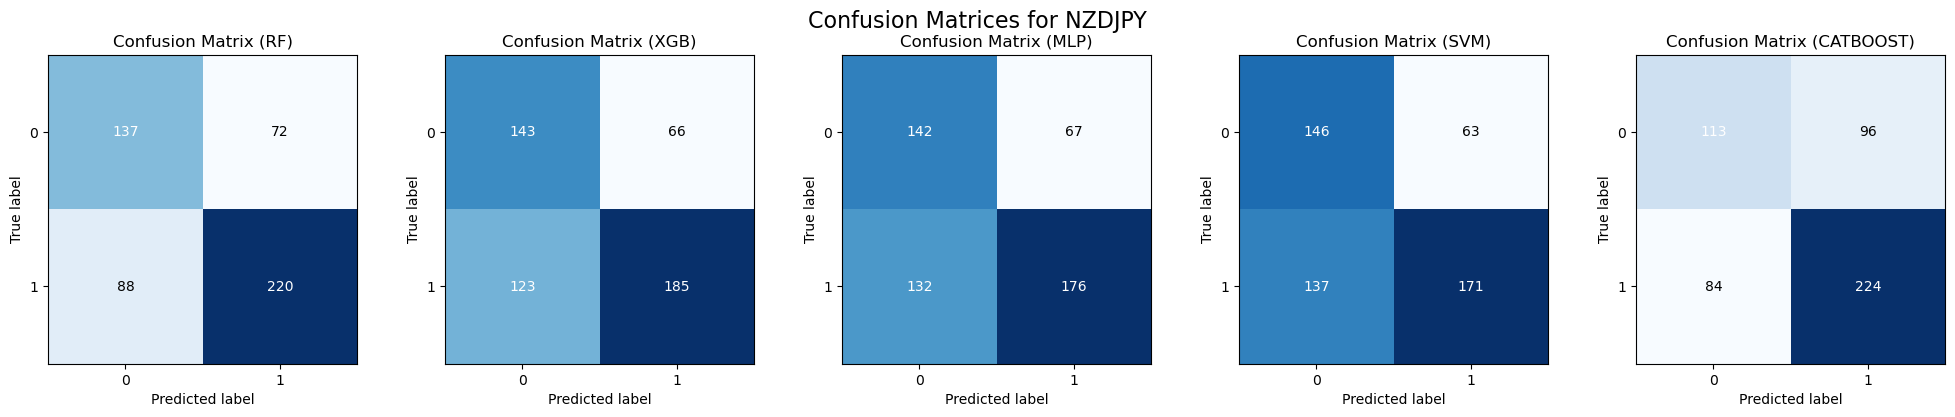

0:	learn: 0.6793407	total: 46.7ms	remaining: 4.62s
1:	learn: 0.6685075	total: 101ms	remaining: 4.97s
2:	learn: 0.6588300	total: 143ms	remaining: 4.61s
3:	learn: 0.6490709	total: 186ms	remaining: 4.47s
4:	learn: 0.6406911	total: 232ms	remaining: 4.41s
5:	learn: 0.6329753	total: 274ms	remaining: 4.3s
6:	learn: 0.6253704	total: 323ms	remaining: 4.29s
7:	learn: 0.6190626	total: 383ms	remaining: 4.41s
8:	learn: 0.6144951	total: 440ms	remaining: 4.45s
9:	learn: 0.6077881	total: 504ms	remaining: 4.54s
10:	learn: 0.6030291	total: 556ms	remaining: 4.5s
11:	learn: 0.5971393	total: 604ms	remaining: 4.43s
12:	learn: 0.5911919	total: 642ms	remaining: 4.29s
13:	learn: 0.5864169	total: 683ms	remaining: 4.19s
14:	learn: 0.5805797	total: 728ms	remaining: 4.13s
15:	learn: 0.5759243	total: 771ms	remaining: 4.05s
16:	learn: 0.5714240	total: 817ms	remaining: 3.99s
17:	learn: 0.5672037	total: 870ms	remaining: 3.96s
18:	learn: 0.5610752	total: 923ms	remaining: 3.93s
19:	learn: 0.5575282	total: 979ms	remainin

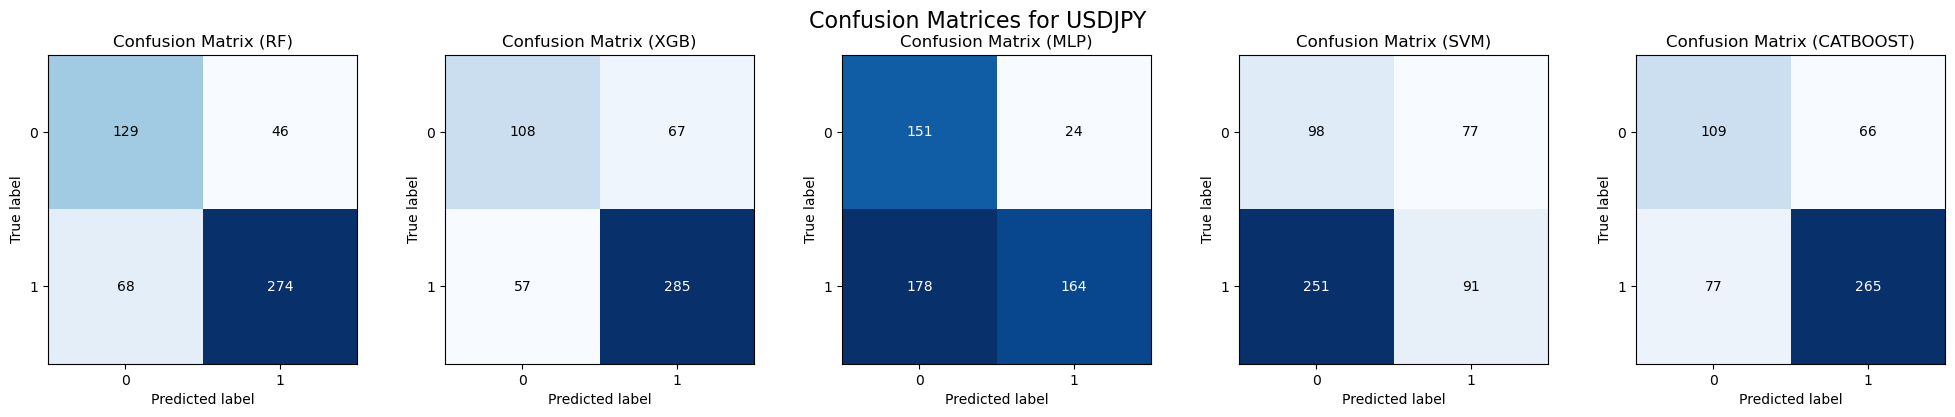

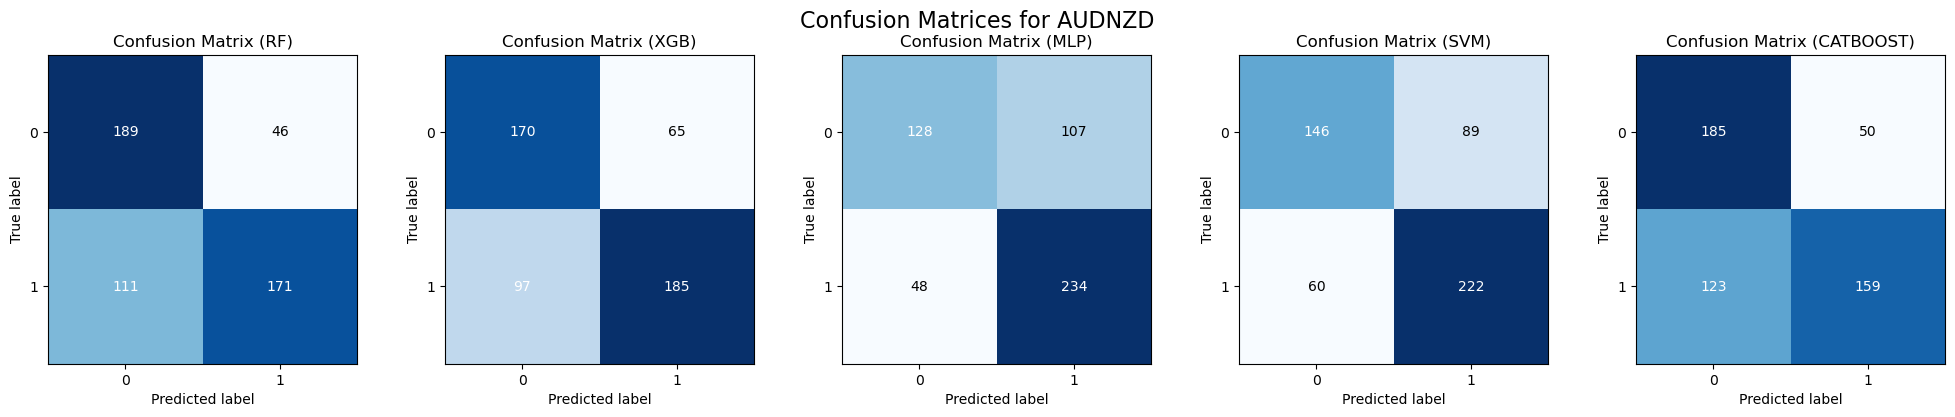

In [32]:
y_pred_all ={}
for sym in symbols:
    X_train = data_all[sym][0]
    y_train = data_all[sym][2]
    X_test = data_all[sym][1]
    y_test = data_all[sym][3]
    # tải các hệ số tốt nhất của từng model
    rf = RandomForestClassifier(**(sorted_cv_df[sym].loc[sorted_cv_df[sym]['model']=='rf', 'best_hyper_param'].values[0]))
    xgb = XGBClassifier(**(sorted_cv_df[sym].loc[sorted_cv_df[sym]['model']=='xgb', 'best_hyper_param'].values[0]))
    mlp = MLPClassifier(**(sorted_cv_df[sym].loc[sorted_cv_df[sym]['model']=='mlp', 'best_hyper_param'].values[0]))
    svm = SVC(**(sorted_cv_df[sym].loc[sorted_cv_df[sym]['model']=='svm', 'best_hyper_param'].values[0]))
    cat = CatBoostClassifier(**(sorted_cv_df[sym].loc[sorted_cv_df[sym]['model']=='catboost', 'best_hyper_param'].values[0]))
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    mlp.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    cat.fit(X_train, y_train)
    # Sau khi huấn luyện sẽ tiến hành dự đoán
    y_pred_rf = rf.predict(X_test)
    y_pred_xgb = xgb.predict(X_test)
    y_pred_mlp = mlp.predict(X_test)
    y_pred_svm = svm.predict(X_test)
    y_pred_cat = cat.predict(X_test)
    y_pred_all[sym] = [y_pred_rf,y_pred_rf,y_pred_mlp,y_pred_svm,y_pred_cat]
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    fig.suptitle(f'Confusion Matrices for {sym}', fontsize=16) 
    for i, (y_pred, ax, model) in enumerate(zip([y_pred_rf, y_pred_xgb, y_pred_mlp, y_pred_svm, y_pred_cat], axes.flatten(), model_name)):
        cm = confusion_matrix(y_test, y_pred)
        classes = unique_labels(y_test, y_pred)
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set(xticks=np.arange(len(classes)),
            yticks=np.arange(len(classes)),
            xticklabels=classes, yticklabels=classes,
            title=f'Confusion Matrix ({model.upper()})',
            ylabel='True label',
            xlabel='Predicted label')

        thresh = cm.max() / 2
        for j in range(cm.shape[0]):
            for k in range(cm.shape[1]):
                ax.text(k, j, format(cm[j, k], 'd'),
                        ha="center", va="center",
                        color="white" if cm[j, k] > thresh else "black")
    plt.tight_layout()
    plt.show()

In [35]:
for sym in symbols:
    prices = data_all_money[sym][4]
    print(f"Tổng lời/lỗ từng mô hình của {sym}:")
    i = 0
    for model in model_name:
        profit = caculate_profit(sym,y_pred_all[sym][i],prices)
        i+=1
        print(f'{model}: {profit}')
    print("----------------------------------------------------------------")

Tổng lời/lỗ từng mô hình của EURCHF:
rf: -13.153500000000154
xgb: -13.153500000000154
mlp: -49.82790000000036
svm: 10.855800000000015
catboost: -26.306999999999817
----------------------------------------------------------------
Tổng lời/lỗ từng mô hình của NZDUSD:
rf: 17.09000000000016
xgb: 17.09000000000016
mlp: -59.52999999999998
svm: -5.190000000000361
catboost: 23.410000000000043
----------------------------------------------------------------
Tổng lời/lỗ từng mô hình của NZDJPY:
rf: 55.09679999999971
xgb: 55.09679999999971
mlp: 10.33559999999964
svm: 48.67499999999981
catboost: 20.86259999999982
----------------------------------------------------------------
Tổng lời/lỗ từng mô hình của USDJPY:
rf: 150.6383999999997
xgb: 150.6383999999997
mlp: 95.75280000000006
svm: 22.050600000000056
catboost: 159.17219999999958
----------------------------------------------------------------
Tổng lời/lỗ từng mô hình của AUDNZD:
rf: 21.948000000000203
xgb: 21.948000000000203
mlp: 34.51499999999